2025-04-08 17:33:26.450640: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 17:33:26.458229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744158806.466383  176090 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744158806.468768  176090 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744158806.475322  176090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda

Class Distribution:
"oa" : 508
"Gout" : 242
"normal" : 693
"Uncertain" : 549
"ref.prev" : 56
"combination of oa, ra" : 3
"ra" : 90
"oa, ra" : 7

Total number of samples in pickle file: 2148

Data Split:
Training samples: 1720
Validation samples: 214
Test samples: 214


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


Epoch 1/5


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]         /home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


  Train Loss: 1.8990 | Train Accuracy: 0.0013
  Validation Loss: 1.1959 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.5213 | TF-IDF Similarity: 0.3185

Epoch 2/5


  Train Loss: 1.2395 | Train Accuracy: 0.0006
  Validation Loss: 1.0279 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6060 | TF-IDF Similarity: 0.3983

Epoch 3/5


  Train Loss: 1.0465 | Train Accuracy: 0.0004
  Validation Loss: 1.0083 | Validation Accuracy: 0.0002
  Semantic Similarity: 0.5465 | TF-IDF Similarity: 0.3007

Epoch 4/5


  Train Loss: 0.9136 | Train Accuracy: 0.0004
  Validation Loss: 0.9646 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6087 | TF-IDF Similarity: 0.3795

Epoch 5/5


  Train Loss: 0.8381 | Train Accuracy: 0.0005
  Validation Loss: 0.9690 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.5817 | TF-IDF Similarity: 0.3465


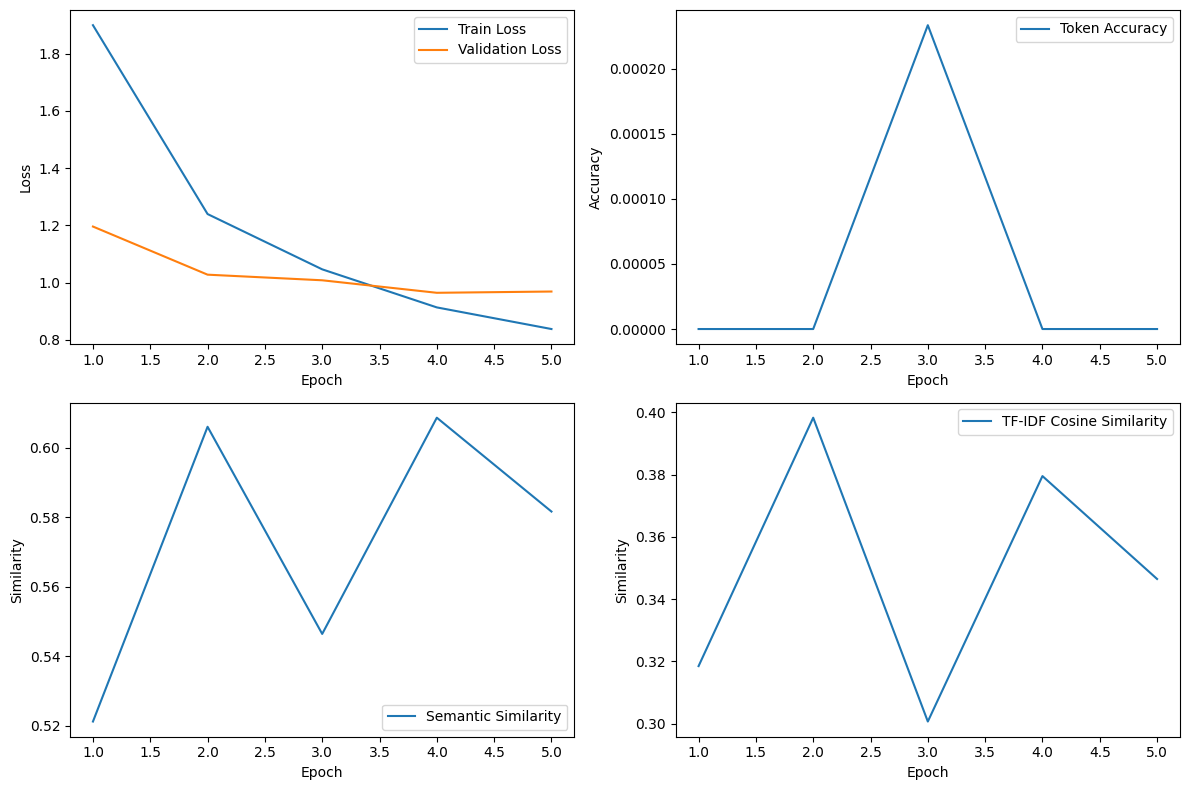


--- Test Evaluation ---
Test Loss: 1.0562 | Test Accuracy: 0.0000
Test Semantic Similarity: 0.5959 | Test TF-IDF Similarity: 0.3709

--- Examples from the Validation Set ---

Example (Index 60)
Raw Report:
[FINDING       ]_x000D_both knee, RA involvement.
both feet and hands, RA, no change._x000D__x000D_[CONCLUSION    ]_x000D_both knee, RA involvement.
both feet and hands, RA, no change._x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report:
both knee, RA involvement. both feet and hands, RA, no change. <|endoftext|>
Generated Report:
both 1st MTP joint, OA with suspicious erosion and soft tissue swelling. 

Example (Index 16)
Raw Report:
[FINDING       ]_x000D_-_x000D__x000D_[CONCLUSION    ]_x000D_degenerative change
hallux valgus, Lt_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report:
-  degenerative change hallux valgus, Lt. <|endoftext|>
Generated Report:
-  No significant interval change. Soft tissue swelling in medial portion of right 1st MTP joint and base area with soft calci

In [1]:
import os
import pickle
import re
import unicodedata
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================================================================
# Text Preprocessing Function (Using the Model's EOS Token)
# =============================================================================
def clean_report(text, eos_token):
    """
    Preprocess the textual report by:
      - Normalizing unicode.
      - Removing non-ASCII characters.
      - Cleaning extra punctuation.
      - Unifying bracketed sections for Finding, Conclusion, and Diagnosis.
      - Discarding the Recommendation section completely.
      - Appending the EOS token (provided as eos_token) if not already present.
    
    Then, remove the section labels ([FINDING], [DIAGNOSIS], [CONCLUSION]) and
    if the report is composed of two identical halves, retain only the first half.
    """
    # Normalize and remove non-ASCII characters.
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'([.!?]){2,}', r'\1', text)
    # Unify section tags.
    text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
    # Remove recommendation section.
    parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
    text = parts[0]
    text = text.replace('_x000D_', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    # Append the EOS token if not already at the end.
    if text and not text.endswith(eos_token):
        text += ' ' + eos_token

    # Remove section tags.
    cleaned = re.sub(r'\[\s*(FINDING|DIAGNOSIS|CONCLUSION)\s*\]', '', text, flags=re.IGNORECASE).strip()
    # Remove the EOS token for further processing.
    cleaned = cleaned.replace(eos_token, '').strip()
    
    # Split the cleaned text into sentences using period as delimiter.
    sentences = [s.strip() for s in re.split(r'\.\s*', cleaned) if s.strip()]
    N = len(sentences)
    # If the number of sentences is even and the first half equals the second half, keep one half.
    if N % 2 == 0 and N > 0:
        half = N // 2
        if all(sentences[i].lower() == sentences[i + half].lower() for i in range(half)):
            final_text = '. '.join(sentences[:half]) + '.'
        else:
            final_text = '. '.join(sentences) + '.'
    else:
        final_text = '. '.join(sentences) + '.'
    
    final_text = final_text.strip() + ' ' + eos_token
    return final_text

# =============================================================================
# Define Albumentations Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

full_img_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

patch_transform = A.Compose([
    A.Resize(112, 112),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# =============================================================================
# Custom PyTorch Dataset
# =============================================================================
class MultiModalDataset(Dataset):
    def __init__(self, pickle_file, tokenizer, full_img_transform, patch_transform, max_patches=34):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
        self.samples = []
        for key, sample in data.items():
            if os.path.exists(sample['file_path']):
                self.samples.append(sample)
        self.tokenizer = tokenizer
        self.full_img_transform = full_img_transform
        self.patch_transform = patch_transform
        self.max_patches = max_patches

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        full_img = cv2.imread(sample['file_path'])
        if full_img is None:
            raise ValueError(f"Image not found: {sample['file_path']}")
        full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
        full_img = self.full_img_transform(image=full_img)['image']
        
        patches = None
        if 'bbx' in sample and sample['bbx'] is not None and len(sample['bbx']) > 0:
            bbx_list = sample['bbx']
            if len(bbx_list) > self.max_patches:
                bbx_list = random.sample(bbx_list, self.max_patches)
            patch_tensors = []
            for patch in bbx_list:
                if patch.ndim == 3 and patch.shape[2] == 3:
                    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                transformed = self.patch_transform(image=patch)['image']
                patch_tensors.append(transformed)
            patches = torch.stack(patch_tensors, dim=0)
        
        raw_report = sample.get('diagnosis', '')
        # Use the tokenizer's EOS token for consistency.
        cleaned_report = clean_report(raw_report, self.tokenizer.eos_token)
        tokenized = self.tokenizer(cleaned_report, truncation=True, max_length=512, return_tensors='pt')
        tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}
        tokenized['labels'] = tokenized['input_ids'].clone()
        
        return {
            'full_img': full_img,
            'patches': patches,
            'input_ids': tokenized['input_ids'],
            'attention_mask': tokenized['attention_mask'],
            'labels': tokenized['labels'],
            'raw_report': raw_report,
            'cleaned_report': cleaned_report,
            'class': sample.get('class', 'Unknown')
        }

# =============================================================================
# Custom Collate Function for DataLoader
# =============================================================================
def collate_fn(batch):
    full_imgs = torch.stack([item['full_img'] for item in batch])
    patch_list = [item['patches'] for item in batch]
    max_patches = max([p.shape[0] if p is not None else 0 for p in patch_list])
    patches_batch = []
    for p in patch_list:
        if p is None:
            patches_batch.append(torch.zeros((max_patches, 3, 112, 112)))
        else:
            num = p.shape[0]
            if num < max_patches:
                pad = torch.zeros((max_patches - num, p.shape[1], p.shape[2], p.shape[3]))
                p = torch.cat([p, pad], dim=0)
            patches_batch.append(p)
    patches_batch = torch.stack(patches_batch, dim=0)
    
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return {
        'full_imgs': full_imgs,
        'patches': patches_batch,
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels,
        'raw_reports': [item['raw_report'] for item in batch],
        'cleaned_reports': [item['cleaned_report'] for item in batch]
    }

# =============================================================================
# Multi-Modal Model Definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super(MultiModalModel, self).__init__()
        # Global Branch: Swin Transformer.
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        
        # Patch Branch: ResNet50.
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()  # Remove final classification head.
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        
        # Feature Combination Module.
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        
        # GPT-2 Decoder for Text Generation (with cross-attention).
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        # Ensure the decoder configuration uses the tokenizer's EOS as the stop token.
        self.decoder.config.eos_token_id = tokenizer.eos_token_id
        self.decoder.config.pad_token_id = tokenizer.eos_token_id
    
    def _pool_patch_features(self, feats):
        if feats.ndim > 2:
            return feats.mean(dim=[2, 3])
        return feats
    
    def forward(self, full_imgs, patches, input_ids, attention_mask, labels=None):
        # Process full image features.
        global_feats = self.global_encoder(full_imgs)  # (B, 1024)
        global_feats = self.global_proj(global_feats)    # (B, 768)
        global_feats = global_feats.unsqueeze(1)         # (B, 1, 768)
        
        # Process patch features.
        B, num_patches, C, H, W = patches.shape
        patches = patches.view(B * num_patches, C, H, W)
        patch_feats = (self.patch_encoder.forward_features(patches)
                       if hasattr(self.patch_encoder, 'forward_features')
                       else self.patch_encoder(patches))
        patch_feats = self._pool_patch_features(patch_feats)  # (B*num_patches, feature_dim)
        patch_feats = self.patch_proj(patch_feats)            # (B*num_patches, 768)
        patch_feats = patch_feats.view(B, num_patches, 768)
        
        # Combine features.
        combined_feats = torch.cat([global_feats, patch_feats], dim=1)  # (B, 1+num_patches, 768)
        attended_feats, _ = self.attention(combined_feats, combined_feats, combined_feats)
        attended_feats = self.norm(attended_feats)
        
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=attended_feats,
            labels=labels
        )
        return outputs

# =============================================================================
# Training and Evaluation Functions
# =============================================================================
def train_epoch(model, dataloader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        full_imgs = batch['full_imgs'].to(device)
        patches = batch['patches'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(full_imgs, patches, input_ids, attention_mask, labels)
            loss = outputs.loss
            logits = outputs.logits
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        mask = labels != -100
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    all_generated = []
    all_ground_truth = []
    
    for batch in tqdm(dataloader, desc="Evaluating", leave=False):
        full_imgs = batch['full_imgs'].to(device)
        patches = batch['patches'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.no_grad():
            outputs = model(full_imgs, patches, input_ids, attention_mask, labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits
            preds = logits.argmax(dim=-1)
            mask = labels != -100
            correct = ((preds == labels) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()
            
            # Generate text for qualitative evaluation using early stopping.
            prompt = input_ids[:, :1]
            B = full_imgs.size(0)
            global_feats = model.global_encoder(full_imgs)
            global_feats = model.global_proj(global_feats).unsqueeze(1)
            
            B, num_patches, C, H, W = patches.shape
            patches_reshaped = patches.view(B * num_patches, C, H, W)
            patch_feats = (model.patch_encoder.forward_features(patches_reshaped)
                           if hasattr(model.patch_encoder, 'forward_features')
                           else model.patch_encoder(patches_reshaped))
            patch_feats = model._pool_patch_features(patch_feats)
            patch_feats = model.patch_proj(patch_feats).view(B, num_patches, 768)
            combined_feats = torch.cat([global_feats, patch_feats], dim=1)
            attended_feats, _ = model.attention(combined_feats, combined_feats, combined_feats)
            attended_feats = model.norm(attended_feats)
            
            generated_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=attended_feats,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,   # Stop generation as soon as EOS token is produced.
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            generated_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
            ground_truth_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch['input_ids']]
            all_generated.extend(generated_texts)
            all_ground_truth.extend(ground_truth_texts)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy, all_generated, all_ground_truth

def compute_semantic_similarity(generated_texts, ground_truth_texts):
    st_model = SentenceTransformer('all-MiniLM-L6-v2')
    gen_emb = st_model.encode(generated_texts, convert_to_tensor=True)
    gt_emb = st_model.encode(ground_truth_texts, convert_to_tensor=True)
    cosine_sim = nn.functional.cosine_similarity(gen_emb, gt_emb)
    return cosine_sim.mean().item()

def compute_tfidf_similarity(generated_texts, ground_truth_texts):
    vectorizer = TfidfVectorizer().fit(generated_texts + ground_truth_texts)
    gen_tfidf = vectorizer.transform(generated_texts)
    gt_tfidf = vectorizer.transform(ground_truth_texts)
    similarities = []
    for i in range(len(generated_texts)):
        sim = cosine_similarity(gen_tfidf[i], gt_tfidf[i])
        similarities.append(sim[0][0])
    return np.mean(similarities)

def plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracies, label="Token Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, semantic_sims, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs, tfidf_sims, label="TF-IDF Cosine Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# Data Setup, Counting & Splitting for Downstream Training
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

global tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Use the tokenizer's own EOS token and set the pad token accordingly.
tokenizer.eos_token = tokenizer.eos_token  
tokenizer.pad_token = tokenizer.eos_token

dataset = MultiModalDataset('updated_merge_json_200x300.pkl', tokenizer, full_img_transform, patch_transform)
class_counts = {}
for sample in dataset.samples:
    cls = sample.get('class', 'Unknown')
    class_counts[cls] = class_counts.get(cls, 0) + 1

print("\nClass Distribution:")
for cls, count in class_counts.items():
    print(f'"{cls}" : {count}')

total_samples = len(dataset)
print(f"\nTotal number of samples in pickle file: {total_samples}")

# Split into 80% training, 10% validation, 10% test.
test_size = int(0.1 * total_samples)
val_size = int(0.1 * total_samples)
train_size_val = total_samples - val_size - test_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size_val, val_size, test_size]
)

print(f"\nData Split:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# =============================================================================
# Fine-Tuning (Downstream Training)
# =============================================================================
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 5  # Adjust number of epochs as needed.
train_losses, val_losses, accuracies, semantic_sims, tfidf_sims = [], [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, val_acc, gen_texts, gt_texts = evaluate(model, val_loader, device)
    sem_sim = compute_semantic_similarity(gen_texts, gt_texts)
    tfidf_sim = compute_tfidf_similarity(gen_texts, gt_texts)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_acc)
    semantic_sims.append(sem_sim)
    tfidf_sims.append(tfidf_sim)
    
    print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"  Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"  Semantic Similarity: {sem_sim:.4f} | TF-IDF Similarity: {tfidf_sim:.4f}")
    
    scheduler.step()

plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims)

# =============================================================================
# Evaluate on Test Data and Print Results
# =============================================================================
test_loss, test_acc, test_gen_texts, test_gt_texts = evaluate(model, test_loader, device)
test_sem_sim = compute_semantic_similarity(test_gen_texts, test_gt_texts)
test_tfidf_sim = compute_tfidf_similarity(test_gen_texts, test_gt_texts)
print("\n--- Test Evaluation ---")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
print(f"Test Semantic Similarity: {test_sem_sim:.4f} | Test TF-IDF Similarity: {test_tfidf_sim:.4f}")

# =============================================================================
# Generate and Print Examples from the Validation Set (10 Random Samples)
# =============================================================================
print("\n--- Examples from the Validation Set ---")
sample_indices = random.sample(range(len(val_dataset)), 10)
for idx in sample_indices:
    example = val_dataset[idx]
    raw_report = example['raw_report']
    cleaned_report = example['cleaned_report']
    full_img = example['full_img'].unsqueeze(0).to(device)
    patches = example['patches'].unsqueeze(0).to(device)
    prompt = example['input_ids'][:1].unsqueeze(0).to(device)
    
    global_feats = model.global_encoder(full_img)
    global_feats = model.global_proj(global_feats).unsqueeze(1)
    
    B, num_patches, C, H, W = patches.shape
    patches_reshaped = patches.view(B * num_patches, C, H, W)
    patch_feats = (model.patch_encoder.forward_features(patches_reshaped)
                   if hasattr(model.patch_encoder, 'forward_features')
                   else model.patch_encoder(patches_reshaped))
    patch_feats = model._pool_patch_features(patch_feats)
    patch_feats = model.patch_proj(patch_feats).view(B, num_patches, 768)
    
    combined_feats = torch.cat([global_feats, patch_feats], dim=1)
    attended_feats, _ = model.attention(combined_feats, combined_feats, combined_feats)
    attended_feats = model.norm(attended_feats)
    
    generated_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=attended_feats,
        attention_mask=torch.ones_like(prompt),
        max_length=100,
        early_stopping=True,  # Stop generation immediately when EOS token is generated.
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_report = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    print(f"\nExample (Index {idx})")
    print("Raw Report:")
    print(raw_report)
    print("Cleaned Report:")
    print(cleaned_report)
    print("Generated Report:")
    print(generated_report)


2025-04-08 17:44:50.083078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 17:44:50.090386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744159490.098360  176355 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744159490.100738  176355 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744159490.107388  176355 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda

Class Distribution:
"oa" : 508
"Gout" : 242
"normal" : 693
"Uncertain" : 549
"ref.prev" : 56
"combination of oa, ra" : 3
"ra" : 90
"oa, ra" : 7

Total number of samples in pickle file: 2148

Data Split:
Training samples: 1720
Validation samples: 214
Test samples: 214


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


Epoch 1/20


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]         /home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


  Train Loss: 1.8490 | Train Accuracy: 0.0018
  Validation Loss: 1.3383 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.5502 | TF-IDF Similarity: 0.3192

Epoch 2/20


  Train Loss: 1.2259 | Train Accuracy: 0.0004
  Validation Loss: 1.1865 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.5941 | TF-IDF Similarity: 0.3964

Epoch 3/20


  Train Loss: 1.0434 | Train Accuracy: 0.0005
  Validation Loss: 1.1702 | Validation Accuracy: 0.0006
  Semantic Similarity: 0.6052 | TF-IDF Similarity: 0.3976

Epoch 4/20


  Train Loss: 0.9209 | Train Accuracy: 0.0004
  Validation Loss: 1.1191 | Validation Accuracy: 0.0006
  Semantic Similarity: 0.5795 | TF-IDF Similarity: 0.3513

Epoch 5/20


  Train Loss: 0.8142 | Train Accuracy: 0.0005
  Validation Loss: 1.1153 | Validation Accuracy: 0.0002
  Semantic Similarity: 0.5944 | TF-IDF Similarity: 0.3716

Epoch 6/20


  Train Loss: 0.7297 | Train Accuracy: 0.0004
  Validation Loss: 1.1193 | Validation Accuracy: 0.0002
  Semantic Similarity: 0.5846 | TF-IDF Similarity: 0.3551

Epoch 7/20


  Train Loss: 0.6569 | Train Accuracy: 0.0002
  Validation Loss: 1.1506 | Validation Accuracy: 0.0002
  Semantic Similarity: 0.6079 | TF-IDF Similarity: 0.3785

Epoch 8/20


  Train Loss: 0.5970 | Train Accuracy: 0.0003
  Validation Loss: 1.1672 | Validation Accuracy: 0.0008
  Semantic Similarity: 0.6121 | TF-IDF Similarity: 0.3924

Epoch 9/20


  Train Loss: 0.5560 | Train Accuracy: 0.0005
  Validation Loss: 1.2005 | Validation Accuracy: 0.0008
  Semantic Similarity: 0.6148 | TF-IDF Similarity: 0.3954

Epoch 10/20


  Train Loss: 0.5357 | Train Accuracy: 0.0003
  Validation Loss: 1.2100 | Validation Accuracy: 0.0008
  Semantic Similarity: 0.6203 | TF-IDF Similarity: 0.3999

Epoch 11/20


  Train Loss: 0.6809 | Train Accuracy: 0.0003
  Validation Loss: 1.1864 | Validation Accuracy: 0.0008
  Semantic Similarity: 0.6049 | TF-IDF Similarity: 0.3800

Epoch 12/20


  Train Loss: 0.6242 | Train Accuracy: 0.0005
  Validation Loss: 1.2120 | Validation Accuracy: 0.0006
  Semantic Similarity: 0.6099 | TF-IDF Similarity: 0.4126

Epoch 13/20


  Train Loss: 0.5599 | Train Accuracy: 0.0006
  Validation Loss: 1.2588 | Validation Accuracy: 0.0006
  Semantic Similarity: 0.6311 | TF-IDF Similarity: 0.4213

Epoch 14/20


  Train Loss: 0.5079 | Train Accuracy: 0.0005
  Validation Loss: 1.3480 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6423 | TF-IDF Similarity: 0.4190

Epoch 15/20


  Train Loss: 0.4558 | Train Accuracy: 0.0004
  Validation Loss: 1.3820 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6171 | TF-IDF Similarity: 0.4243

Epoch 16/20


  Train Loss: 0.4087 | Train Accuracy: 0.0005
  Validation Loss: 1.4097 | Validation Accuracy: 0.0006
  Semantic Similarity: 0.6344 | TF-IDF Similarity: 0.4207

Epoch 17/20


  Train Loss: 0.3732 | Train Accuracy: 0.0003
  Validation Loss: 1.4521 | Validation Accuracy: 0.0006
  Semantic Similarity: 0.5978 | TF-IDF Similarity: 0.3934

Epoch 18/20


  Train Loss: 0.3392 | Train Accuracy: 0.0005
  Validation Loss: 1.4737 | Validation Accuracy: 0.0002
  Semantic Similarity: 0.6033 | TF-IDF Similarity: 0.4048

Epoch 19/20


  Train Loss: 0.3147 | Train Accuracy: 0.0003
  Validation Loss: 1.5478 | Validation Accuracy: 0.0006
  Semantic Similarity: 0.6062 | TF-IDF Similarity: 0.3982

Epoch 20/20


  Train Loss: 0.2908 | Train Accuracy: 0.0005
  Validation Loss: 1.6048 | Validation Accuracy: 0.0004
  Semantic Similarity: 0.6296 | TF-IDF Similarity: 0.4157


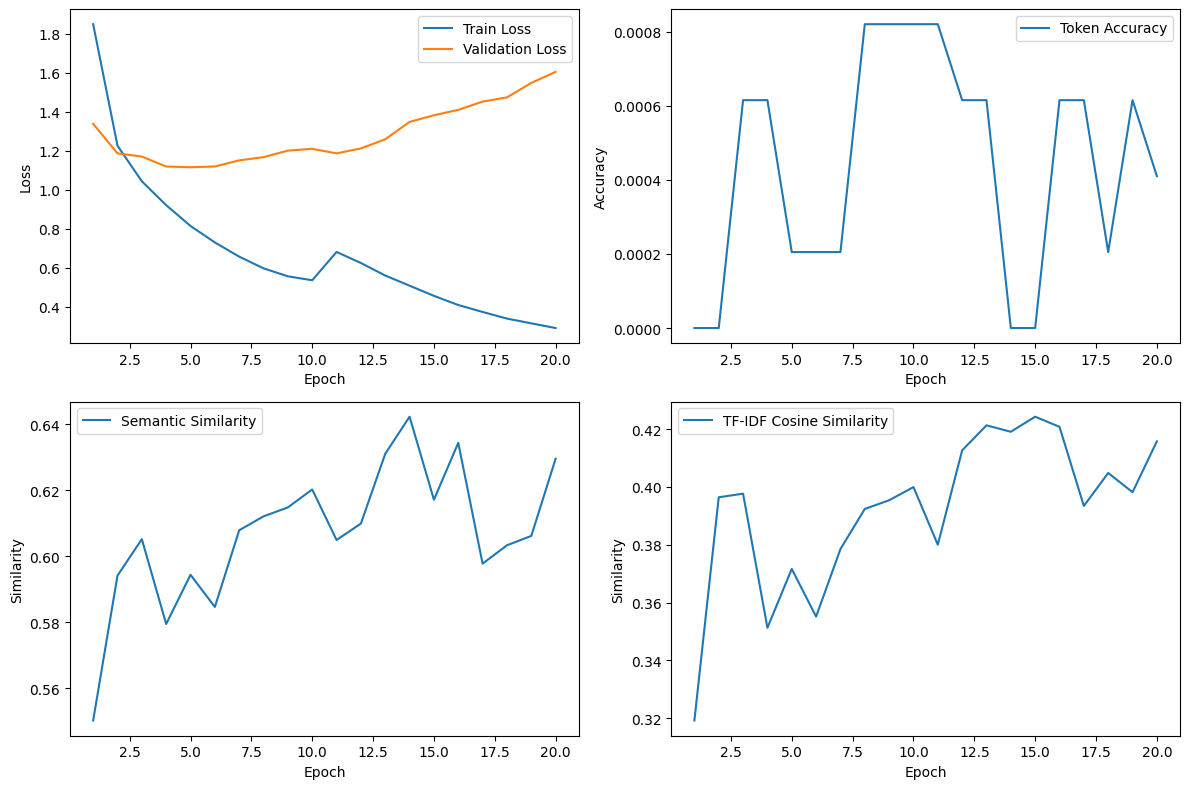


--- Test Evaluation ---
Test Loss: 1.5546 | Test Accuracy: 0.0006
Test Semantic Similarity: 0.6325 | Test TF-IDF Similarity: 0.4276

--- Examples from the Validation Set ---

Example (Index 33)
Raw Report:
[ Finding ]_x000D_
hallux valgus, both._x000D_
[ Conclusion ]_x000D_
hallux valgus, both._x000D_
[ Recommend ]_x000D_

Cleaned Report:
hallux valgus, both. <|endoftext|>
Generated Report:
hallux valgus, both. 

Example (Index 78)
Raw Report:
[FINDING       ]_x000D_Degenerative changes_x000D__x000D_[CONCLUSION    ]_x000D_Degenerative changes_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report:
Degenerative changes  Degenerative changes. <|endoftext|>
Generated Report:
Degenerative changes  Degeneration change. Hallux valgus, both Osteopenia and pes planus deformity at Rt 2nd and 5th MT head. Diffuse osteopenic thickening -> RA involvement more likely degenerative state of DIP joint space narrowing with subchondral sclerosis such as gouty arthritis or tibiofibular joint erosions at m

In [1]:
import os
import pickle
import re
import unicodedata
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================================================================
# Text Preprocessing Function (Using the Model's EOS Token)
# =============================================================================
def clean_report(text, eos_token):
    """
    Preprocess the textual report by:
      - Normalizing unicode.
      - Removing non-ASCII characters.
      - Cleaning extra punctuation.
      - Unifying bracketed sections for Finding, Conclusion, and Diagnosis.
      - Discarding the Recommendation section completely.
      - Appending the EOS token (provided as eos_token) if not already present.
    
    Then, remove the section labels ([FINDING], [DIAGNOSIS], [CONCLUSION]) and
    if the report is composed of two identical halves, retain only the first half.
    """
    # Normalize and remove non-ASCII characters.
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'([.!?]){2,}', r'\1', text)
    # Unify section tags.
    text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
    # Remove recommendation section.
    parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
    text = parts[0]
    text = text.replace('_x000D_', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    # Append the EOS token if not already at the end.
    if text and not text.endswith(eos_token):
        text += ' ' + eos_token

    # Remove section tags.
    cleaned = re.sub(r'\[\s*(FINDING|DIAGNOSIS|CONCLUSION)\s*\]', '', text, flags=re.IGNORECASE).strip()
    # Remove the EOS token for further processing.
    cleaned = cleaned.replace(eos_token, '').strip()
    
    # Split the cleaned text into sentences using period as delimiter.
    sentences = [s.strip() for s in re.split(r'\.\s*', cleaned) if s.strip()]
    N = len(sentences)
    # If the number of sentences is even and the first half equals the second half, keep one half.
    if N % 2 == 0 and N > 0:
        half = N // 2
        if all(sentences[i].lower() == sentences[i + half].lower() for i in range(half)):
            final_text = '. '.join(sentences[:half]) + '.'
        else:
            final_text = '. '.join(sentences) + '.'
    else:
        final_text = '. '.join(sentences) + '.'
    
    final_text = final_text.strip() + ' ' + eos_token
    return final_text

# =============================================================================
# Define Albumentations Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

full_img_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

patch_transform = A.Compose([
    A.Resize(112, 112),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# =============================================================================
# Custom PyTorch Dataset
# =============================================================================
class MultiModalDataset(Dataset):
    def __init__(self, pickle_file, tokenizer, full_img_transform, patch_transform, max_patches=34):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
        self.samples = []
        for key, sample in data.items():
            if os.path.exists(sample['file_path']):
                self.samples.append(sample)
        self.tokenizer = tokenizer
        self.full_img_transform = full_img_transform
        self.patch_transform = patch_transform
        self.max_patches = max_patches

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        full_img = cv2.imread(sample['file_path'])
        if full_img is None:
            raise ValueError(f"Image not found: {sample['file_path']}")
        full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
        full_img = self.full_img_transform(image=full_img)['image']
        
        patches = None
        if 'bbx' in sample and sample['bbx'] is not None and len(sample['bbx']) > 0:
            bbx_list = sample['bbx']
            if len(bbx_list) > self.max_patches:
                bbx_list = random.sample(bbx_list, self.max_patches)
            patch_tensors = []
            for patch in bbx_list:
                if patch.ndim == 3 and patch.shape[2] == 3:
                    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                transformed = self.patch_transform(image=patch)['image']
                patch_tensors.append(transformed)
            patches = torch.stack(patch_tensors, dim=0)
        
        raw_report = sample.get('diagnosis', '')
        # Use the tokenizer's EOS token for consistency.
        cleaned_report = clean_report(raw_report, self.tokenizer.eos_token)
        tokenized = self.tokenizer(cleaned_report, truncation=True, max_length=512, return_tensors='pt')
        tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}
        tokenized['labels'] = tokenized['input_ids'].clone()
        
        return {
            'full_img': full_img,
            'patches': patches,
            'input_ids': tokenized['input_ids'],
            'attention_mask': tokenized['attention_mask'],
            'labels': tokenized['labels'],
            'raw_report': raw_report,
            'cleaned_report': cleaned_report,
            'class': sample.get('class', 'Unknown')
        }

# =============================================================================
# Custom Collate Function for DataLoader
# =============================================================================
def collate_fn(batch):
    full_imgs = torch.stack([item['full_img'] for item in batch])
    patch_list = [item['patches'] for item in batch]
    max_patches = max([p.shape[0] if p is not None else 0 for p in patch_list])
    patches_batch = []
    for p in patch_list:
        if p is None:
            patches_batch.append(torch.zeros((max_patches, 3, 112, 112)))
        else:
            num = p.shape[0]
            if num < max_patches:
                pad = torch.zeros((max_patches - num, p.shape[1], p.shape[2], p.shape[3]))
                p = torch.cat([p, pad], dim=0)
            patches_batch.append(p)
    patches_batch = torch.stack(patches_batch, dim=0)
    
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return {
        'full_imgs': full_imgs,
        'patches': patches_batch,
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels,
        'raw_reports': [item['raw_report'] for item in batch],
        'cleaned_reports': [item['cleaned_report'] for item in batch]
    }

# =============================================================================
# Multi-Modal Model Definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super(MultiModalModel, self).__init__()
        # Global Branch: Swin Transformer.
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        
        # Patch Branch: ResNet50.
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()  # Remove final classification head.
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        
        # Feature Combination Module.
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        
        # GPT-2 Decoder for Text Generation (with cross-attention).
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        # Ensure the decoder configuration uses the tokenizer's EOS as the stop token.
        self.decoder.config.eos_token_id = tokenizer.eos_token_id
        self.decoder.config.pad_token_id = tokenizer.eos_token_id
    
    def _pool_patch_features(self, feats):
        if feats.ndim > 2:
            return feats.mean(dim=[2, 3])
        return feats
    
    def forward(self, full_imgs, patches, input_ids, attention_mask, labels=None):
        # Process full image features.
        global_feats = self.global_encoder(full_imgs)  # (B, 1024)
        global_feats = self.global_proj(global_feats)    # (B, 768)
        global_feats = global_feats.unsqueeze(1)         # (B, 1, 768)
        
        # Process patch features.
        B, num_patches, C, H, W = patches.shape
        patches = patches.view(B * num_patches, C, H, W)
        patch_feats = (self.patch_encoder.forward_features(patches)
                       if hasattr(self.patch_encoder, 'forward_features')
                       else self.patch_encoder(patches))
        patch_feats = self._pool_patch_features(patch_feats)  # (B*num_patches, feature_dim)
        patch_feats = self.patch_proj(patch_feats)            # (B*num_patches, 768)
        patch_feats = patch_feats.view(B, num_patches, 768)
        
        # Combine features.
        combined_feats = torch.cat([global_feats, patch_feats], dim=1)  # (B, 1+num_patches, 768)
        attended_feats, _ = self.attention(combined_feats, combined_feats, combined_feats)
        attended_feats = self.norm(attended_feats)
        
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=attended_feats,
            labels=labels
        )
        return outputs

# =============================================================================
# Training and Evaluation Functions
# =============================================================================
def train_epoch(model, dataloader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        full_imgs = batch['full_imgs'].to(device)
        patches = batch['patches'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(full_imgs, patches, input_ids, attention_mask, labels)
            loss = outputs.loss
            logits = outputs.logits
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        mask = labels != -100
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    all_generated = []
    all_ground_truth = []
    
    for batch in tqdm(dataloader, desc="Evaluating", leave=False):
        full_imgs = batch['full_imgs'].to(device)
        patches = batch['patches'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.no_grad():
            outputs = model(full_imgs, patches, input_ids, attention_mask, labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits
            preds = logits.argmax(dim=-1)
            mask = labels != -100
            correct = ((preds == labels) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()
            
            # Generate text for qualitative evaluation using early stopping.
            prompt = input_ids[:, :1]
            B = full_imgs.size(0)
            global_feats = model.global_encoder(full_imgs)
            global_feats = model.global_proj(global_feats).unsqueeze(1)
            
            B, num_patches, C, H, W = patches.shape
            patches_reshaped = patches.view(B * num_patches, C, H, W)
            patch_feats = (model.patch_encoder.forward_features(patches_reshaped)
                           if hasattr(model.patch_encoder, 'forward_features')
                           else model.patch_encoder(patches_reshaped))
            patch_feats = model._pool_patch_features(patch_feats)
            patch_feats = model.patch_proj(patch_feats).view(B, num_patches, 768)
            combined_feats = torch.cat([global_feats, patch_feats], dim=1)
            attended_feats, _ = model.attention(combined_feats, combined_feats, combined_feats)
            attended_feats = model.norm(attended_feats)
            
            generated_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=attended_feats,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,   # Stop generation as soon as EOS token is produced.
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            generated_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
            ground_truth_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch['input_ids']]
            all_generated.extend(generated_texts)
            all_ground_truth.extend(ground_truth_texts)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy, all_generated, all_ground_truth

def compute_semantic_similarity(generated_texts, ground_truth_texts):
    st_model = SentenceTransformer('all-MiniLM-L6-v2')
    gen_emb = st_model.encode(generated_texts, convert_to_tensor=True)
    gt_emb = st_model.encode(ground_truth_texts, convert_to_tensor=True)
    cosine_sim = nn.functional.cosine_similarity(gen_emb, gt_emb)
    return cosine_sim.mean().item()

def compute_tfidf_similarity(generated_texts, ground_truth_texts):
    vectorizer = TfidfVectorizer().fit(generated_texts + ground_truth_texts)
    gen_tfidf = vectorizer.transform(generated_texts)
    gt_tfidf = vectorizer.transform(ground_truth_texts)
    similarities = []
    for i in range(len(generated_texts)):
        sim = cosine_similarity(gen_tfidf[i], gt_tfidf[i])
        similarities.append(sim[0][0])
    return np.mean(similarities)

def plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracies, label="Token Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, semantic_sims, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs, tfidf_sims, label="TF-IDF Cosine Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# Data Setup, Counting & Splitting for Downstream Training
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

global tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Use the tokenizer's own EOS token and set the pad token accordingly.
tokenizer.eos_token = tokenizer.eos_token  
tokenizer.pad_token = tokenizer.eos_token

dataset = MultiModalDataset('updated_merge_json_200x300.pkl', tokenizer, full_img_transform, patch_transform)
class_counts = {}
for sample in dataset.samples:
    cls = sample.get('class', 'Unknown')
    class_counts[cls] = class_counts.get(cls, 0) + 1

print("\nClass Distribution:")
for cls, count in class_counts.items():
    print(f'"{cls}" : {count}')

total_samples = len(dataset)
print(f"\nTotal number of samples in pickle file: {total_samples}")

# Split into 80% training, 10% validation, 10% test.
test_size = int(0.1 * total_samples)
val_size = int(0.1 * total_samples)
train_size_val = total_samples - val_size - test_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size_val, val_size, test_size]
)

print(f"\nData Split:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# =============================================================================
# Fine-Tuning (Downstream Training)
# =============================================================================
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 20  # Adjust number of epochs as needed.
train_losses, val_losses, accuracies, semantic_sims, tfidf_sims = [], [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, val_acc, gen_texts, gt_texts = evaluate(model, val_loader, device)
    sem_sim = compute_semantic_similarity(gen_texts, gt_texts)
    tfidf_sim = compute_tfidf_similarity(gen_texts, gt_texts)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_acc)
    semantic_sims.append(sem_sim)
    tfidf_sims.append(tfidf_sim)
    
    print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"  Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"  Semantic Similarity: {sem_sim:.4f} | TF-IDF Similarity: {tfidf_sim:.4f}")
    
    scheduler.step()

plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims)

# =============================================================================
# Evaluate on Test Data and Print Results
# =============================================================================
test_loss, test_acc, test_gen_texts, test_gt_texts = evaluate(model, test_loader, device)
test_sem_sim = compute_semantic_similarity(test_gen_texts, test_gt_texts)
test_tfidf_sim = compute_tfidf_similarity(test_gen_texts, test_gt_texts)
print("\n--- Test Evaluation ---")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
print(f"Test Semantic Similarity: {test_sem_sim:.4f} | Test TF-IDF Similarity: {test_tfidf_sim:.4f}")

# =============================================================================
# Generate and Print Examples from the Validation Set (10 Random Samples)
# =============================================================================
print("\n--- Examples from the Validation Set ---")
sample_indices = random.sample(range(len(val_dataset)), 20)
for idx in sample_indices:
    example = val_dataset[idx]
    raw_report = example['raw_report']
    cleaned_report = example['cleaned_report']
    full_img = example['full_img'].unsqueeze(0).to(device)
    patches = example['patches'].unsqueeze(0).to(device)
    prompt = example['input_ids'][:1].unsqueeze(0).to(device)
    
    global_feats = model.global_encoder(full_img)
    global_feats = model.global_proj(global_feats).unsqueeze(1)
    
    B, num_patches, C, H, W = patches.shape
    patches_reshaped = patches.view(B * num_patches, C, H, W)
    patch_feats = (model.patch_encoder.forward_features(patches_reshaped)
                   if hasattr(model.patch_encoder, 'forward_features')
                   else model.patch_encoder(patches_reshaped))
    patch_feats = model._pool_patch_features(patch_feats)
    patch_feats = model.patch_proj(patch_feats).view(B, num_patches, 768)
    
    combined_feats = torch.cat([global_feats, patch_feats], dim=1)
    attended_feats, _ = model.attention(combined_feats, combined_feats, combined_feats)
    attended_feats = model.norm(attended_feats)
    
    generated_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=attended_feats,
        attention_mask=torch.ones_like(prompt),
        max_length=100,
        early_stopping=True,  # Stop generation immediately when EOS token is generated.
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_report = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    print(f"\nExample (Index {idx})")
    print("Raw Report:")
    print(raw_report)
    print("Cleaned Report:")
    print(cleaned_report)
    print("Generated Report:")
    print(generated_report)


2025-04-08 18:43:35.251199: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 18:43:35.258521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744163015.266422  176973 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744163015.268810  176973 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744163015.275581  176973 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda

Class Distribution:
"oa" : 508
"Gout" : 242
"normal" : 693
"Uncertain" : 549
"ref.prev" : 56
"combination of oa, ra" : 3
"ra" : 90
"oa, ra" : 7

Total number of samples in pickle file: 2148

Data Split:
Training samples: 1720
Validation samples: 214
Test samples: 214


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


Epoch 1/50


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]         /home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


  Train Loss: 2.0629 | Train Accuracy: 0.0006
  Validation Loss: 1.4450 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.5618 | TF-IDF Similarity: 0.3935

Epoch 2/50


  Train Loss: 1.3951 | Train Accuracy: 0.0002
  Validation Loss: 1.2703 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6182 | TF-IDF Similarity: 0.4741

Epoch 3/50


  Train Loss: 1.1852 | Train Accuracy: 0.0001
  Validation Loss: 1.2328 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6624 | TF-IDF Similarity: 0.5286

Epoch 4/50


  Train Loss: 1.0554 | Train Accuracy: 0.0003
  Validation Loss: 1.2122 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6414 | TF-IDF Similarity: 0.4836

Epoch 5/50


  Train Loss: 0.9336 | Train Accuracy: 0.0002
  Validation Loss: 1.2103 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6446 | TF-IDF Similarity: 0.4879

Epoch 6/50


  Train Loss: 0.8348 | Train Accuracy: 0.0002
  Validation Loss: 1.2487 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6461 | TF-IDF Similarity: 0.4927

Epoch 7/50


  Train Loss: 0.7471 | Train Accuracy: 0.0002
  Validation Loss: 1.2583 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6520 | TF-IDF Similarity: 0.4944

Epoch 8/50


  Train Loss: 0.6897 | Train Accuracy: 0.0003
  Validation Loss: 1.2944 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6450 | TF-IDF Similarity: 0.5026

Epoch 9/50


  Train Loss: 0.6493 | Train Accuracy: 0.0004
  Validation Loss: 1.3253 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6671 | TF-IDF Similarity: 0.5144

Epoch 10/50


  Train Loss: 0.6235 | Train Accuracy: 0.0002
  Validation Loss: 1.3287 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6749 | TF-IDF Similarity: 0.5072

Epoch 11/50


  Train Loss: 0.7772 | Train Accuracy: 0.0004
  Validation Loss: 1.3134 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6555 | TF-IDF Similarity: 0.4802

Epoch 12/50


  Train Loss: 0.7105 | Train Accuracy: 0.0003
  Validation Loss: 1.3437 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6563 | TF-IDF Similarity: 0.4888

Epoch 13/50


  Train Loss: 0.6425 | Train Accuracy: 0.0003
  Validation Loss: 1.4048 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6514 | TF-IDF Similarity: 0.4924

Epoch 14/50


  Train Loss: 0.5807 | Train Accuracy: 0.0003
  Validation Loss: 1.4567 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6664 | TF-IDF Similarity: 0.5262

Epoch 15/50


  Train Loss: 0.5309 | Train Accuracy: 0.0005
  Validation Loss: 1.5317 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6736 | TF-IDF Similarity: 0.5059

Epoch 16/50


  Train Loss: 0.4790 | Train Accuracy: 0.0003
  Validation Loss: 1.5519 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6480 | TF-IDF Similarity: 0.4655

Epoch 17/50


  Train Loss: 0.4281 | Train Accuracy: 0.0003
  Validation Loss: 1.6035 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6710 | TF-IDF Similarity: 0.5169

Epoch 18/50


  Train Loss: 0.3930 | Train Accuracy: 0.0002
  Validation Loss: 1.6907 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6691 | TF-IDF Similarity: 0.5069

Epoch 19/50


  Train Loss: 0.3624 | Train Accuracy: 0.0004
  Validation Loss: 1.6939 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6671 | TF-IDF Similarity: 0.4863

Epoch 20/50


  Train Loss: 0.3307 | Train Accuracy: 0.0004
  Validation Loss: 1.8023 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6851 | TF-IDF Similarity: 0.5234

Epoch 21/50


  Train Loss: 0.3119 | Train Accuracy: 0.0004
  Validation Loss: 1.7724 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6719 | TF-IDF Similarity: 0.5165

Epoch 22/50


  Train Loss: 0.2839 | Train Accuracy: 0.0004
  Validation Loss: 1.8599 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6743 | TF-IDF Similarity: 0.4943

Epoch 23/50


  Train Loss: 0.2716 | Train Accuracy: 0.0005
  Validation Loss: 1.8682 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6807 | TF-IDF Similarity: 0.5345

Epoch 24/50


  Train Loss: 0.2481 | Train Accuracy: 0.0004
  Validation Loss: 1.9021 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6749 | TF-IDF Similarity: 0.5088

Epoch 25/50


  Train Loss: 0.2331 | Train Accuracy: 0.0004
  Validation Loss: 1.9331 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6712 | TF-IDF Similarity: 0.5021

Epoch 26/50


  Train Loss: 0.2270 | Train Accuracy: 0.0004
  Validation Loss: 1.9460 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6508 | TF-IDF Similarity: 0.4863

Epoch 27/50


  Train Loss: 0.2117 | Train Accuracy: 0.0003
  Validation Loss: 1.9636 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6711 | TF-IDF Similarity: 0.5000

Epoch 28/50


  Train Loss: 0.2041 | Train Accuracy: 0.0003
  Validation Loss: 1.9762 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6922 | TF-IDF Similarity: 0.5282

Epoch 29/50


  Train Loss: 0.2016 | Train Accuracy: 0.0003
  Validation Loss: 1.9917 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6697 | TF-IDF Similarity: 0.5095

Epoch 30/50


  Train Loss: 0.1997 | Train Accuracy: 0.0004
  Validation Loss: 1.9865 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6684 | TF-IDF Similarity: 0.5085

Epoch 31/50


  Train Loss: 0.3450 | Train Accuracy: 0.0004
  Validation Loss: 1.7784 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6728 | TF-IDF Similarity: 0.5280

Epoch 32/50


  Train Loss: 0.3510 | Train Accuracy: 0.0003
  Validation Loss: 1.8072 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6753 | TF-IDF Similarity: 0.5058

Epoch 33/50


  Train Loss: 0.3194 | Train Accuracy: 0.0004
  Validation Loss: 1.9016 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6611 | TF-IDF Similarity: 0.4944

Epoch 34/50


  Train Loss: 0.2862 | Train Accuracy: 0.0003
  Validation Loss: 1.8521 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6646 | TF-IDF Similarity: 0.5027

Epoch 35/50


  Train Loss: 0.2699 | Train Accuracy: 0.0004
  Validation Loss: 1.9973 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6730 | TF-IDF Similarity: 0.5096

Epoch 36/50


  Train Loss: 0.2652 | Train Accuracy: 0.0002
  Validation Loss: 1.9126 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6834 | TF-IDF Similarity: 0.5188

Epoch 37/50


  Train Loss: 0.2496 | Train Accuracy: 0.0005
  Validation Loss: 1.9825 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6747 | TF-IDF Similarity: 0.4891

Epoch 38/50


  Train Loss: 0.2360 | Train Accuracy: 0.0003
  Validation Loss: 2.0117 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6611 | TF-IDF Similarity: 0.4855

Epoch 39/50


  Train Loss: 0.2332 | Train Accuracy: 0.0003
  Validation Loss: 2.0059 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6665 | TF-IDF Similarity: 0.5103

Epoch 40/50


  Train Loss: 0.2222 | Train Accuracy: 0.0002
  Validation Loss: 2.1114 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6733 | TF-IDF Similarity: 0.5232

Epoch 41/50


  Train Loss: 0.2098 | Train Accuracy: 0.0003
  Validation Loss: 2.1166 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6630 | TF-IDF Similarity: 0.4951

Epoch 42/50


  Train Loss: 0.2008 | Train Accuracy: 0.0003
  Validation Loss: 2.0907 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6538 | TF-IDF Similarity: 0.4886

Epoch 43/50


  Train Loss: 0.1953 | Train Accuracy: 0.0003
  Validation Loss: 2.0815 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6594 | TF-IDF Similarity: 0.4995

Epoch 44/50


  Train Loss: 0.1828 | Train Accuracy: 0.0004
  Validation Loss: 2.1169 | Validation Accuracy: 0.0005
  Semantic Similarity: 0.6634 | TF-IDF Similarity: 0.4900

Epoch 45/50


  Train Loss: 0.1802 | Train Accuracy: 0.0003
  Validation Loss: 2.1448 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6616 | TF-IDF Similarity: 0.5143

Epoch 46/50


  Train Loss: 0.1742 | Train Accuracy: 0.0003
  Validation Loss: 2.2089 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6562 | TF-IDF Similarity: 0.4973

Epoch 47/50


  Train Loss: 0.1656 | Train Accuracy: 0.0003
  Validation Loss: 2.2332 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6542 | TF-IDF Similarity: 0.4936

Epoch 48/50


  Train Loss: 0.1570 | Train Accuracy: 0.0003
  Validation Loss: 2.2772 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6523 | TF-IDF Similarity: 0.4887

Epoch 49/50


  Train Loss: 0.1470 | Train Accuracy: 0.0003
  Validation Loss: 2.2942 | Validation Accuracy: 0.0003
  Semantic Similarity: 0.6455 | TF-IDF Similarity: 0.4817

Epoch 50/50


  Train Loss: 0.1393 | Train Accuracy: 0.0003
  Validation Loss: 2.2939 | Validation Accuracy: 0.0000
  Semantic Similarity: 0.6483 | TF-IDF Similarity: 0.4898


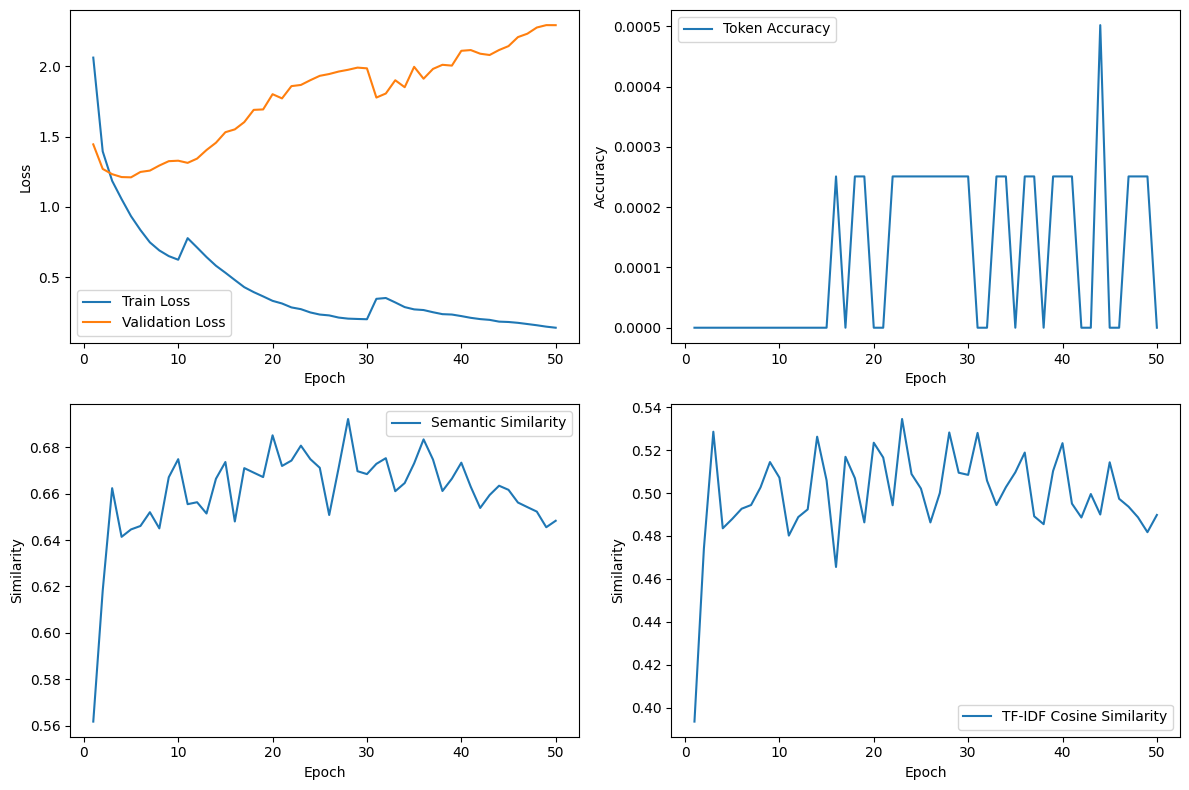


--- Test Evaluation ---
Test Loss: 2.1665 | Test Accuracy: 0.0003
Test Semantic Similarity: 0.6630 | Test TF-IDF Similarity: 0.4984

--- Examples from the Validation Set ---

Example (Index 115)
Raw Report:
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
soft tissue bulging with subtle increased density in medial portion of both 1st MTP joint with bone erostion in both 1st metatarsal head._x000D_
  --- gouty arthritis._x000D_
[ Recommend ]_x000D_

Cleaned Report:
soft tissue bulging with subtle increased density in medial portion of both 1st MTP joint with bone erostion in both 1st metatarsal head. --- gouty arthritis. <|endoftext|>
Generated Report:
soft tissue swelling with subtle increased soft tissue density around both 1st and 2nd MTP joint. large bone erosion of left 2nd PIP, right 3rd PIP joint. ---> possible gouty arthritis 

Example (Index 119)
Raw Report:
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
small enthesophyte with multiple small calcifications of the left calcane

In [1]:
import os
import pickle
import re
import unicodedata
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================================================================
# Text Preprocessing Function (Using the Model's EOS Token)
# =============================================================================
def clean_report(text, eos_token):
    """
    Preprocess the textual report by:
      - Normalizing unicode.
      - Removing non-ASCII characters.
      - Cleaning extra punctuation.
      - Unifying bracketed sections for Finding, Conclusion, and Diagnosis.
      - Discarding the Recommendation section completely.
      - Comparing the content of the FINDING and CONCLUSION sections and, if they are identical,
        removing the CONCLUSION section.
      - Appending the EOS token (provided as eos_token) if not already present.
    """
    # Normalize unicode and remove non-ASCII characters.
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'([.!?]){2,}', r'\1', text)
    
    # Normalize section tags.
    text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
    text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
    
    # Discard the recommendation section.
    parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
    text = parts[0]
    
    # Compare the FINDING and CONCLUSION sections.
    finding_match = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
    conclusion_match = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
    if finding_match and conclusion_match:
        finding_text = finding_match.group(1).strip()
        conclusion_text = conclusion_match.group(1).strip()
        # If the two sections are identical (ignoring case), remove the CONCLUSION section.
        if finding_text.lower() == conclusion_text.lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
    
    # Remove any remaining section tags.
    text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
    
    # Replace extra markers and normalize whitespace.
    text = text.replace('_x000D_', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Append the EOS token if not already present.
    if text and not text.endswith(eos_token):
        text += ' ' + eos_token
    return text


# =============================================================================
# Define Albumentations Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

full_img_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

patch_transform = A.Compose([
    A.Resize(112, 112),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

# =============================================================================
# Custom PyTorch Dataset
# =============================================================================
class MultiModalDataset(Dataset):
    def __init__(self, pickle_file, tokenizer, full_img_transform, patch_transform, max_patches=34):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
        self.samples = []
        for key, sample in data.items():
            if os.path.exists(sample['file_path']):
                self.samples.append(sample)
        self.tokenizer = tokenizer
        self.full_img_transform = full_img_transform
        self.patch_transform = patch_transform
        self.max_patches = max_patches

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        full_img = cv2.imread(sample['file_path'])
        if full_img is None:
            raise ValueError(f"Image not found: {sample['file_path']}")
        full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
        full_img = self.full_img_transform(image=full_img)['image']
        
        patches = None
        if 'bbx' in sample and sample['bbx'] is not None and len(sample['bbx']) > 0:
            bbx_list = sample['bbx']
            if len(bbx_list) > self.max_patches:
                bbx_list = random.sample(bbx_list, self.max_patches)
            patch_tensors = []
            for patch in bbx_list:
                if patch.ndim == 3 and patch.shape[2] == 3:
                    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                transformed = self.patch_transform(image=patch)['image']
                patch_tensors.append(transformed)
            patches = torch.stack(patch_tensors, dim=0)
        
        raw_report = sample.get('diagnosis', '')
        # Use the tokenizer's EOS token for consistency.
        cleaned_report = clean_report(raw_report, self.tokenizer.eos_token)
        tokenized = self.tokenizer(cleaned_report, truncation=True, max_length=512, return_tensors='pt')
        tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}
        tokenized['labels'] = tokenized['input_ids'].clone()
        
        return {
            'full_img': full_img,
            'patches': patches,
            'input_ids': tokenized['input_ids'],
            'attention_mask': tokenized['attention_mask'],
            'labels': tokenized['labels'],
            'raw_report': raw_report,
            'cleaned_report': cleaned_report,
            'class': sample.get('class', 'Unknown')
        }

# =============================================================================
# Custom Collate Function for DataLoader
# =============================================================================
def collate_fn(batch):
    full_imgs = torch.stack([item['full_img'] for item in batch])
    patch_list = [item['patches'] for item in batch]
    max_patches = max([p.shape[0] if p is not None else 0 for p in patch_list])
    patches_batch = []
    for p in patch_list:
        if p is None:
            patches_batch.append(torch.zeros((max_patches, 3, 112, 112)))
        else:
            num = p.shape[0]
            if num < max_patches:
                pad = torch.zeros((max_patches - num, p.shape[1], p.shape[2], p.shape[3]))
                p = torch.cat([p, pad], dim=0)
            patches_batch.append(p)
    patches_batch = torch.stack(patches_batch, dim=0)
    
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return {
        'full_imgs': full_imgs,
        'patches': patches_batch,
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels,
        'raw_reports': [item['raw_report'] for item in batch],
        'cleaned_reports': [item['cleaned_report'] for item in batch]
    }

# =============================================================================
# Multi-Modal Model Definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super(MultiModalModel, self).__init__()
        # Global Branch: Swin Transformer.
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)
        
        # Patch Branch: ResNet50.
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()  # Remove final classification head.
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)
        
        # Feature Combination Module.
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        
        # GPT-2 Decoder for Text Generation (with cross-attention).
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        # Ensure the decoder configuration uses the tokenizer's EOS as the stop token.
        self.decoder.config.eos_token_id = tokenizer.eos_token_id
        self.decoder.config.pad_token_id = tokenizer.eos_token_id
    
    def _pool_patch_features(self, feats):
        if feats.ndim > 2:
            return feats.mean(dim=[2, 3])
        return feats
    
    def forward(self, full_imgs, patches, input_ids, attention_mask, labels=None):
        # Process full image features.
        global_feats = self.global_encoder(full_imgs)  # (B, 1024)
        global_feats = self.global_proj(global_feats)    # (B, 768)
        global_feats = global_feats.unsqueeze(1)         # (B, 1, 768)
        
        # Process patch features.
        B, num_patches, C, H, W = patches.shape
        patches = patches.view(B * num_patches, C, H, W)
        patch_feats = (self.patch_encoder.forward_features(patches)
                       if hasattr(self.patch_encoder, 'forward_features')
                       else self.patch_encoder(patches))
        patch_feats = self._pool_patch_features(patch_feats)  # (B*num_patches, feature_dim)
        patch_feats = self.patch_proj(patch_feats)            # (B*num_patches, 768)
        patch_feats = patch_feats.view(B, num_patches, 768)
        
        # Combine features.
        combined_feats = torch.cat([global_feats, patch_feats], dim=1)  # (B, 1+num_patches, 768)
        attended_feats, _ = self.attention(combined_feats, combined_feats, combined_feats)
        attended_feats = self.norm(attended_feats)
        
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=attended_feats,
            labels=labels
        )
        return outputs

# =============================================================================
# Training and Evaluation Functions
# =============================================================================
def train_epoch(model, dataloader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        full_imgs = batch['full_imgs'].to(device)
        patches = batch['patches'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(full_imgs, patches, input_ids, attention_mask, labels)
            loss = outputs.loss
            logits = outputs.logits
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        mask = labels != -100
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    all_generated = []
    all_ground_truth = []
    
    for batch in tqdm(dataloader, desc="Evaluating", leave=False):
        full_imgs = batch['full_imgs'].to(device)
        patches = batch['patches'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.no_grad():
            outputs = model(full_imgs, patches, input_ids, attention_mask, labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits
            preds = logits.argmax(dim=-1)
            mask = labels != -100
            correct = ((preds == labels) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()
            
            # Generate text for qualitative evaluation using early stopping.
            prompt = input_ids[:, :1]
            B = full_imgs.size(0)
            global_feats = model.global_encoder(full_imgs)
            global_feats = model.global_proj(global_feats).unsqueeze(1)
            
            B, num_patches, C, H, W = patches.shape
            patches_reshaped = patches.view(B * num_patches, C, H, W)
            patch_feats = (model.patch_encoder.forward_features(patches_reshaped)
                           if hasattr(model.patch_encoder, 'forward_features')
                           else model.patch_encoder(patches_reshaped))
            patch_feats = model._pool_patch_features(patch_feats)
            patch_feats = model.patch_proj(patch_feats).view(B, num_patches, 768)
            combined_feats = torch.cat([global_feats, patch_feats], dim=1)
            attended_feats, _ = model.attention(combined_feats, combined_feats, combined_feats)
            attended_feats = model.norm(attended_feats)
            
            generated_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=attended_feats,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                early_stopping=True,   # Stop generation as soon as EOS token is produced.
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            generated_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
            ground_truth_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch['input_ids']]
            all_generated.extend(generated_texts)
            all_ground_truth.extend(ground_truth_texts)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy, all_generated, all_ground_truth

def compute_semantic_similarity(generated_texts, ground_truth_texts):
    st_model = SentenceTransformer('all-MiniLM-L6-v2')
    gen_emb = st_model.encode(generated_texts, convert_to_tensor=True)
    gt_emb = st_model.encode(ground_truth_texts, convert_to_tensor=True)
    cosine_sim = nn.functional.cosine_similarity(gen_emb, gt_emb)
    return cosine_sim.mean().item()

def compute_tfidf_similarity(generated_texts, ground_truth_texts):
    vectorizer = TfidfVectorizer().fit(generated_texts + ground_truth_texts)
    gen_tfidf = vectorizer.transform(generated_texts)
    gt_tfidf = vectorizer.transform(ground_truth_texts)
    similarities = []
    for i in range(len(generated_texts)):
        sim = cosine_similarity(gen_tfidf[i], gt_tfidf[i])
        similarities.append(sim[0][0])
    return np.mean(similarities)

def plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracies, label="Token Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, semantic_sims, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs, tfidf_sims, label="TF-IDF Cosine Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# Data Setup, Counting & Splitting for Downstream Training
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

global tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Use the tokenizer's own EOS token and set the pad token accordingly.
tokenizer.eos_token = tokenizer.eos_token  
tokenizer.pad_token = tokenizer.eos_token

dataset = MultiModalDataset('updated_merge_json_200x300.pkl', tokenizer, full_img_transform, patch_transform)
class_counts = {}
for sample in dataset.samples:
    cls = sample.get('class', 'Unknown')
    class_counts[cls] = class_counts.get(cls, 0) + 1

print("\nClass Distribution:")
for cls, count in class_counts.items():
    print(f'"{cls}" : {count}')

total_samples = len(dataset)
print(f"\nTotal number of samples in pickle file: {total_samples}")

# Split into 80% training, 10% validation, 10% test.
test_size = int(0.1 * total_samples)
val_size = int(0.1 * total_samples)
train_size_val = total_samples - val_size - test_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size_val, val_size, test_size]
)

print(f"\nData Split:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# =============================================================================
# Fine-Tuning (Downstream Training)
# =============================================================================
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 50  # Adjust number of epochs as needed.
train_losses, val_losses, accuracies, semantic_sims, tfidf_sims = [], [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, val_acc, gen_texts, gt_texts = evaluate(model, val_loader, device)
    sem_sim = compute_semantic_similarity(gen_texts, gt_texts)
    tfidf_sim = compute_tfidf_similarity(gen_texts, gt_texts)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_acc)
    semantic_sims.append(sem_sim)
    tfidf_sims.append(tfidf_sim)
    
    print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"  Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"  Semantic Similarity: {sem_sim:.4f} | TF-IDF Similarity: {tfidf_sim:.4f}")
    
    scheduler.step()

plot_metrics(train_losses, val_losses, accuracies, semantic_sims, tfidf_sims)

# =============================================================================
# Evaluate on Test Data and Print Results
# =============================================================================
test_loss, test_acc, test_gen_texts, test_gt_texts = evaluate(model, test_loader, device)
test_sem_sim = compute_semantic_similarity(test_gen_texts, test_gt_texts)
test_tfidf_sim = compute_tfidf_similarity(test_gen_texts, test_gt_texts)
print("\n--- Test Evaluation ---")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
print(f"Test Semantic Similarity: {test_sem_sim:.4f} | Test TF-IDF Similarity: {test_tfidf_sim:.4f}")

# =============================================================================
# Generate and Print Examples from the Validation Set (10 Random Samples)
# =============================================================================
print("\n--- Examples from the Validation Set ---")
sample_indices = random.sample(range(len(val_dataset)), 20)
for idx in sample_indices:
    example = val_dataset[idx]
    raw_report = example['raw_report']
    cleaned_report = example['cleaned_report']
    full_img = example['full_img'].unsqueeze(0).to(device)
    patches = example['patches'].unsqueeze(0).to(device)
    prompt = example['input_ids'][:1].unsqueeze(0).to(device)
    
    global_feats = model.global_encoder(full_img)
    global_feats = model.global_proj(global_feats).unsqueeze(1)
    
    B, num_patches, C, H, W = patches.shape
    patches_reshaped = patches.view(B * num_patches, C, H, W)
    patch_feats = (model.patch_encoder.forward_features(patches_reshaped)
                   if hasattr(model.patch_encoder, 'forward_features')
                   else model.patch_encoder(patches_reshaped))
    patch_feats = model._pool_patch_features(patch_feats)
    patch_feats = model.patch_proj(patch_feats).view(B, num_patches, 768)
    
    combined_feats = torch.cat([global_feats, patch_feats], dim=1)
    attended_feats, _ = model.attention(combined_feats, combined_feats, combined_feats)
    attended_feats = model.norm(attended_feats)
    
    generated_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=attended_feats,
        attention_mask=torch.ones_like(prompt),
        max_length=100,
        early_stopping=True,  # Stop generation immediately when EOS token is generated.
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_report = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    print(f"\nExample (Index {idx})")
    print("Raw Report:")
    print(raw_report)
    print("Cleaned Report:")
    print(cleaned_report)
    print("Generated Report:")
    print(generated_report)
